In [3]:
import pyro
import pyro.distributions as dist
import pyro
import torch

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from models_manual_guide import GMM

print(f'running for n_comp = {11}')
pyro.clear_param_store()
svi = GMM(n_comp=11, infr='svi')

running for n_comp = 11


/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


Initializing object for inference method svi


In [8]:
svi.tensor_train.shape

torch.Size([28338, 19])

Determining best seed for initialization
Best seed determined after 100 random initializations:
seed = 37, initial_loss = 867599.0
Running SVI iterations

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
.............................................

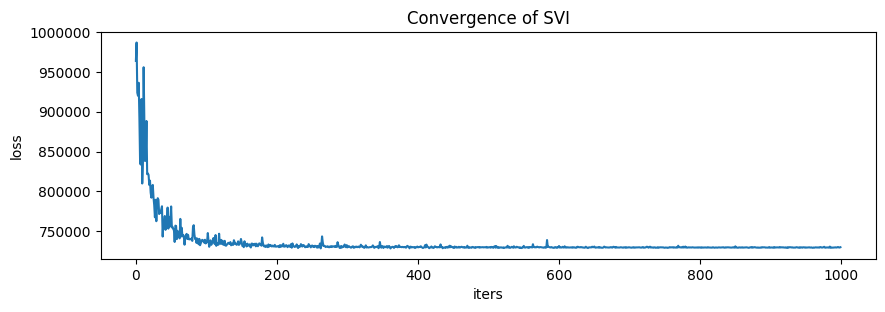

In [9]:
svi.svi_itr = 1000
los = svi.inference()
svi.plot_svi_convergence(los)

In [40]:
svi.mcmc = None
svi.generate_stats()

[{'num_samples': 28338,
  'num_iterations': 1000,
  'exec_time': 959.8155944347382},
 None]

In [10]:
samps = svi.get_mean_svi_est_manual_guide()
samps

{'weights': tensor([7.1366e-14, 6.8732e-01, 1.4072e-02, 5.4217e-02, 1.4058e-08, 1.4301e-01,
         3.7398e-07, 4.3628e-20, 1.1165e-10, 8.9026e-06, 1.0137e-01]),
 'scale': tensor([1.0156, 0.9995, 1.0003, 1.0134, 1.0369, 0.9990, 0.9992, 1.0204, 1.0091,
         1.0100, 1.0020]),
 'locs': tensor([[ 1.1186e-02, -5.1916e-04,  6.5644e-03, -4.6078e-04, -5.2000e-03,
           9.1221e-04, -6.1991e-03, -9.5318e-03,  2.6126e-03,  4.7487e-03,
           1.5765e-03, -7.2336e-03,  3.3312e-03, -8.6697e-04, -7.2561e-04,
          -2.6329e-03,  4.9350e-03,  5.8295e-04,  6.0639e-03],
         [-3.8560e-03,  1.4605e-04,  6.0376e-03,  2.6984e-03, -2.0189e-03,
           5.9137e-03, -4.2654e-03,  2.4205e-03, -6.3891e-03, -4.4377e-03,
           8.6979e-03,  5.0054e-03, -3.6058e-04,  5.4059e-03,  2.3938e-03,
          -6.7495e-04, -3.0114e-04,  6.9011e-03,  1.8681e-03],
         [ 7.1798e-04, -1.5795e-02,  4.7437e-04, -1.4369e-03,  2.6692e-03,
           2.3850e-03,  9.9225e-04, -1.4975e-03,  2.3069e-04,

In [11]:
resps = svi.get_posterior_resp()
resps

tensor([[6.2739e-14, 6.9134e-01, 1.4073e-02,  ..., 1.0457e-10, 8.2840e-06,
         9.8460e-02],
        [7.1996e-14, 6.8610e-01, 1.4303e-02,  ..., 1.1267e-10, 9.0677e-06,
         1.0330e-01],
        [6.3810e-14, 6.9110e-01, 1.4067e-02,  ..., 1.0536e-10, 8.3417e-06,
         9.8839e-02],
        ...,
        [9.5168e-14, 6.7888e-01, 1.3441e-02,  ..., 1.2727e-10, 1.0525e-05,
         9.5684e-02],
        [9.5135e-14, 6.8470e-01, 1.2618e-02,  ..., 1.2930e-10, 1.0534e-05,
         9.4054e-02],
        [9.9031e-14, 6.8095e-01, 1.2499e-02,  ..., 1.3192e-10, 1.0684e-05,
         9.4477e-02]])

In [15]:
torch.isnan(resps).sum()

tensor(473)

In [28]:
nl_idx = []
for _, i in enumerate(resps):
    if torch.isnan(i).sum():
        nl_idx.append(_)

In [19]:
svi.tensor_test[1169]

tensor([-0.2430,  4.5325,  0.0545,  1.2367,  6.4919,  0.2997, -3.9864, -0.8842,
        -0.9613, -0.2796, -1.7346, -0.1747, -0.4535, -0.2866,  4.1323,  9.4949,
         3.7787,  0.3388, -0.0119])

In [21]:
w = samps['weights']
l = samps['locs']
s = samps['scale']
prob_list = []
lis = []
for i in range(11):
    t = torch.eye(19) * s[i]
    lis.append(t)
f = torch.stack(lis)
distri = dist.MultivariateNormal(l, f)

In [32]:
for idx in nl_idx:
    d = svi.tensor_test[idx]
    prob = torch.exp(distri.log_prob(d))

    print(f'd: {d}')
    print(f'prob: {prob}')
    numerator = w * prob
    print(f'numerator: {numerator}')            
    denom = numerator.sum()
    print(denom)
    probs = numerator / denom
    print(probs)
    prob_list.append(probs)


d: tensor([-0.2430,  4.5325,  0.0545,  1.2367,  6.4919,  0.2997, -3.9864, -0.8842,
        -0.9613, -0.2796, -1.7346, -0.1747, -0.4535, -0.2866,  4.1323,  9.4949,
         3.7787,  0.3388, -0.0119])
prob: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
numerator: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
d: tensor([-0.5085, -6.1519, -0.8516,  0.7601,  6.3767,  0.7070,  4.1740,  0.3519,
        -1.2238, -0.3355, -6.5521, -0.8029,  0.2534,  1.6128,  1.7307,  6.3416,
         4.9456, -6.9016,  0.1548])
prob: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
numerator: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.)
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
d: tensor([-0.5495, -6.2394,  5.9854,  0.6067,  7.0438,  0.8232,  3.5686,  0.4844,
        -1.4223, -0.4053,  0.4026, -0.7091,  0.3394,  3.2054,  2.0704,  7.4099,
         5.4165, -7.7126,  0.1645])
prob: t

#### Running using function

In [33]:
from run_gmm import run_gmm

running for n_comp = 11


/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


Initializing object for inference method svi
size of train tensor: torch.Size([28338, 19])
size of test tensor: torch.Size([11330, 19])
number of iterations 1000
Determining best seed for initialization
Best seed determined after 100 random initializations:
seed = 37, initial_loss = 867599.0
Running SVI iterations

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................

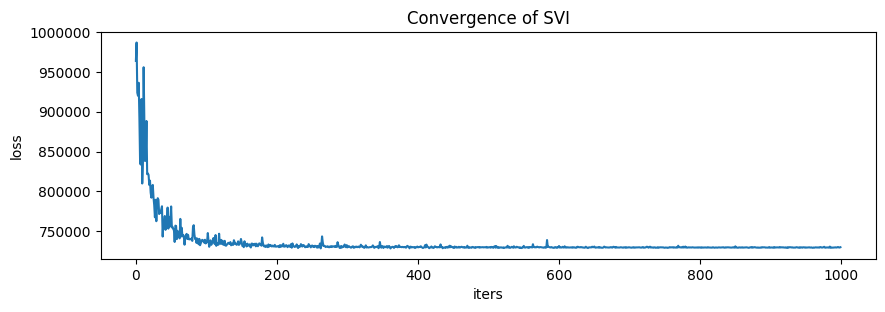

In [34]:
resp_temp, nl_idx_temp = run_gmm()